# Evaluation

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from summit import *
from multitask import *


from rdkit import Chem

import torch

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from IPython.display import clear_output
from copy import deepcopy
import pathlib
import json

In [86]:
def make_average_plot(results: List[Experiment], ax, label=None, color=None):
    objective = results[0].domain.output_variables[0].name
    yields = [r.data[objective] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=2, c=color)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1, color=color)

def make_comparison_plot(*args, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1)
    for arg in args:
        make_average_plot(arg['results'], ax, label=arg["label"], color=arg.get("color"))
    fontdict = fontdict={"size":12}
    ax.legend(prop=fontdict, framealpha=0.0)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
#     ax.set_ylabel('Yield', fontdict=fontdict)
#     ax.set_xlabel('Reactions', fontdict=fontdict)
    ax.tick_params(direction='in')
    return ax

## Import Files

In [79]:
#Multitask 
multitask_path = pathlib.Path("../data/multitask_results")
multitask_dirs = multitask_path.glob("*")
all_experiments = {}
for multitask_dir in multitask_dirs:
    json_files  = multitask_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = multitask_dir.parts[-1]
    all_experiments[name] = experiments

In [80]:
# Baugmartner STBO
baumgartner_results_path = Path("../data/baumgartner_suzuki/results_stbo")
json_files  = baumgartner_results_path.glob("*.json")
all_experiments_baumgartner_stbo = []
for json_file in json_files:
    with open(json_file, "r") as f:
        runner_dict = json.load(f)
        all_experiments_baumgartner_stbo.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))

In [81]:
# Baugmartner STBO Mixed
baumgartner_results_path = Path("../data/baumgartner_suzuki/results_stbo_mixed_domain")
json_files  = baumgartner_results_path.glob("*.json")
all_experiments_baumgartner_stbo_mixed = []
for json_file in json_files:
    with open(json_file, "r") as f:
        runner_dict = json.load(f)
        all_experiments_baumgartner_stbo_mixed.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))

In [82]:
# Reizman STBO
reizman_path = pathlib.Path("../data/reizman_suzuki")
reizman_results_path = reizman_path.glob("results_stbo_case_*/")
all_experiments_reizman_stbo = {}
for results_dir in reizman_results_path:
    json_files  = results_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = results_dir.parts[-1]
    all_experiments_reizman_stbo[name] = experiments

In [83]:
# Reizman STBO Mixed
reizman_path = pathlib.Path("../data/reizman_suzuki")
reizman_results_path = reizman_path.glob("results_stbo_mixed_case_*/")
all_experiments_reizman_stbo_mixed = {}
for results_dir in reizman_results_path:
    json_files  = results_dir.glob("*.json")
    experiments = []
    for json_file in json_files:
        with open(json_file, "r") as f:
            runner_dict = json.load(f)
            experiments.append(ExperimentalEmulator.from_dict(runner_dict["experiment"]))
    name = results_dir.parts[-1]
    all_experiments_reizman_stbo_mixed[name] = experiments

## Plotting

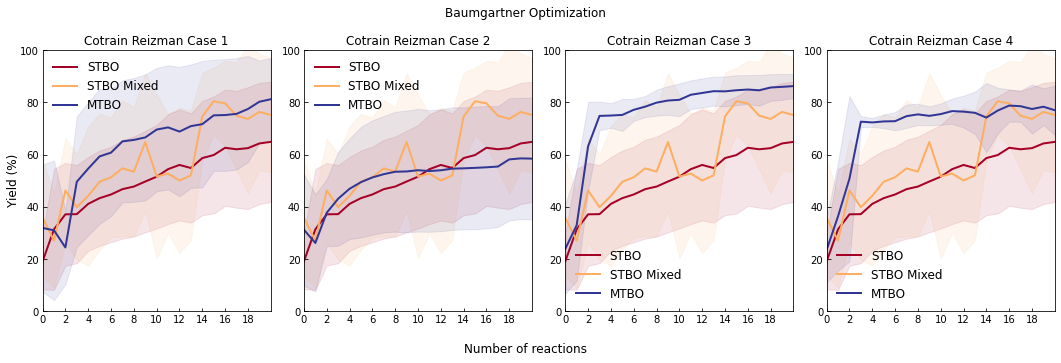

In [87]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
for i in range(1,5):
    ax = fig.add_subplot(1,4, k)
    stbo_exps = all_experiments_baumgartner_stbo
    stbo_exps_mixed = all_experiments_baumgartner_stbo_mixed
    mtbo_exps = all_experiments[f"results_baumgartner_suzuki_cotrain_reizman_suzuki_case_{i}"]
    make_comparison_plot(
        dict(results=stbo_exps, label="STBO", color="#a50026"),
        dict(results=stbo_exps_mixed, label="STBO Mixed", color="#fdae61"),
        dict(
            results=mtbo_exps,
            label="MTBO",
            color="#313695"
        ),
        ax=ax
    )
    ax.set_title(f"Cotrain Reizman Case {i}")
    ax.set_xlim(0,20)
    ax.set_ylim(0,100)
    k+=1
fig.suptitle("Baumgartner Optimization")
fig.supxlabel("Number of reactions")
fig.supylabel("Yield (%)")
fig.tight_layout()
fig.savefig("../figures/baumgertner_reizman_one_cotraining_optimization.png", dpi=300, transparent=True)

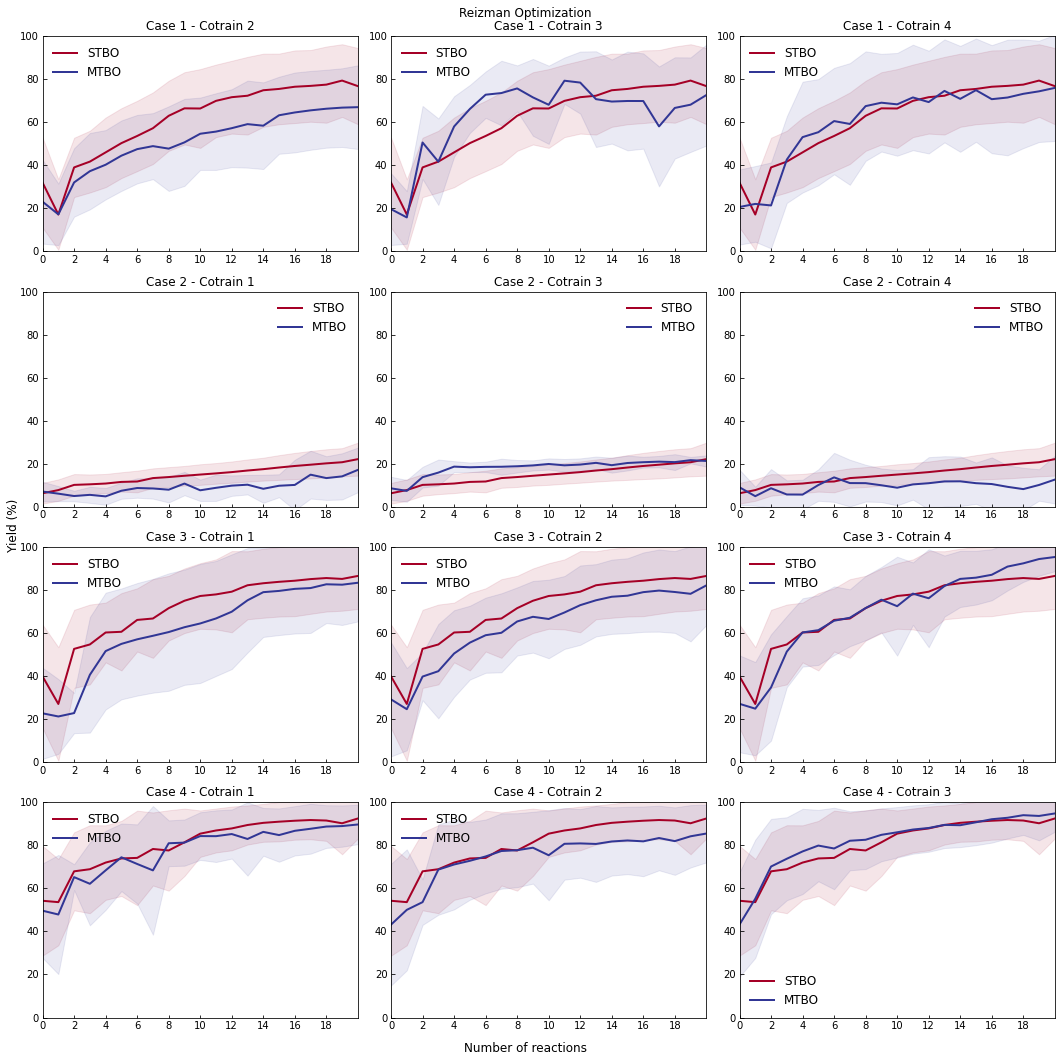

In [92]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
k = 1
for i in range(1,5):
    for j in range(1,5):
        if i != j:
            ax = fig.add_subplot(4,3, k)
            stbo_exps = all_experiments_reizman_stbo[f"results_stbo_case_{i}"]
#             stbo_exps_mixed = all_experiments_reizman_stbo_mixed[f"results_stbo_mixed_case_{i}"]
            mtbo_exps = all_experiments[f"results_reizman_suzuki_case_{i}_cotrain_reizman_suzuki_case_{j}"]
            make_comparison_plot(
                dict(results=stbo_exps, label="STBO", color="#a50026"),
#                 dict(results=stbo_exps_mixed, label="STBO Mixed", color="#fdae61"),
                dict(results=mtbo_exps,label="MTBO",color="#313695"),
                ax=ax
            )
            ax.set_title(f"Case {i} - Cotrain {j}")
            ax.set_ylim(0,100)
            k+=1
fig.suptitle("Reizman Optimization")
fig.supxlabel("Number of reactions")
fig.supylabel("Yield (%)")
fig.tight_layout()
# fig.savefig("../figures/reizman_reizman_one_cotraining_optimization.png", dpi=300)

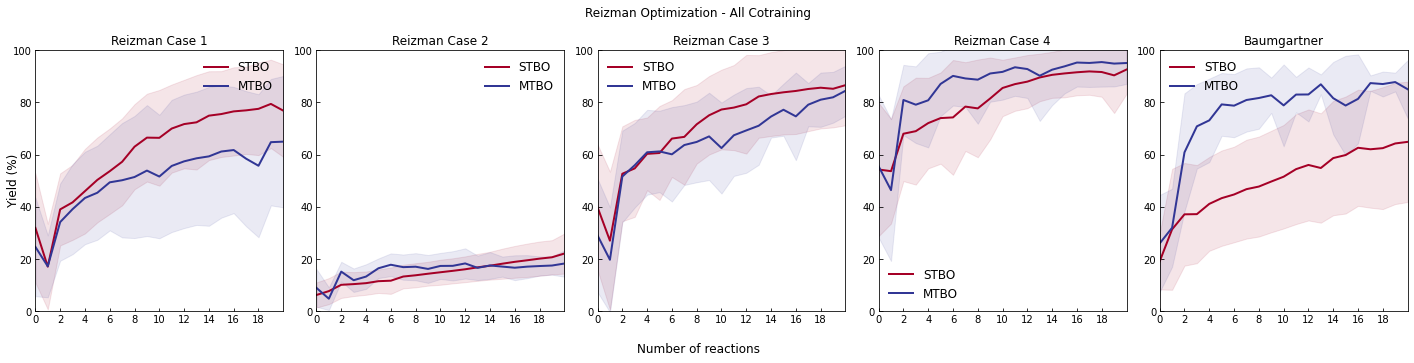

In [93]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.2, hspace=0.5)

# Reizman
k = 1
for i in range(1,5):
    ax = fig.add_subplot(1,5, k)
    stbo_exps = all_experiments_reizman_stbo[f"results_stbo_case_{i}"]
    mtbo_exps = all_experiments[f"results_reizman_suzuki_case_{i}"]
    make_comparison_plot(
        dict(results=stbo_exps, label="STBO", color="#a50026"),
        dict(
            results=mtbo_exps,
            label="MTBO",
            color="#313695"
        ),
        ax=ax
    )
    ax.set_title(f"Reizman Case {i}")
    ax.set_xlim(0,20)
    ax.set_ylim(0,100)
    k+=1
    
# Baumgartner
ax = fig.add_subplot(1,5, 5)
stbo_exps = all_experiments_baumgartner_stbo
mtbo_exps = all_experiments[f"results_baumgartner_suzuki"]
make_comparison_plot(
    dict(results=stbo_exps, label="STBO", color="#a50026"),
    dict(
        results=mtbo_exps,
        label="MTBO",
        color="#313695"
    ),
    ax=ax
)


# Formatting
ax.set_title(f"Baumgartner")
ax.set_xlim(0,20)
ax.set_ylim(0,100)
fig.suptitle("Reizman Optimization - All Cotraining")
fig.supxlabel("Number of reactions")
fig.supylabel("Yield (%)")
fig.tight_layout()
fig.savefig("../figures/multitask_four_cotraining_results.png", dpi=300)

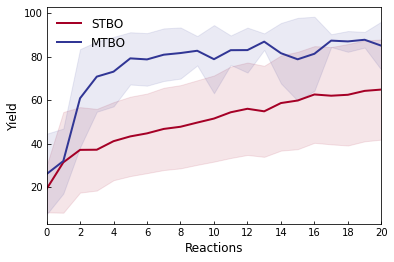

In [99]:
fig, ax = plt.subplots(1)
stbo_exps = all_experiments_baumgartner_stbo
mtbo_exps = all_experiments[f"results_baumgartner_suzuki"]
make_comparison_plot(
    dict(results=stbo_exps, label="STBO", color="#a50026"),
    dict(
        results=mtbo_exps,
        label="MTBO",
        color="#313695"
    ),
    ax=ax
)
ax.set_xlim(0,20)
ax.set_xticks(np.arange(0, 22, 2).astype(int))
ax.set_ylabel('Yield', fontdict=fontdict)
ax.set_xlabel('Reactions', fontdict=fontdict)
fig.savefig("../figures/baumgartner_suzuki_reizman_four_cotraining.png", dpi=300, transparent=False)

## Visualize Catalyst Choices

In [63]:
def visualize_catalyst_choice(experiments):
    avg_yields = [
        exp.data.groupby("catalyst_smiles")["yld"].mean()
        for exp in experiments
    ]
    df =pd.concat(avg_yields, axis=1).fillna(0)
    avg_yields = df.mean(axis=1)
    cat_counts = [
        exp.data["catalyst_smiles"].value_counts()
        for exp in experiments
    ]
    df =pd.concat(cat_counts, axis=1).fillna(0)
    cat_counts = df.mean(axis=1)
    # cat_counts = exps[0].data["catalyst_smiles"].value_counts()
    return Chem.Draw.MolsToGridImage(
        [Chem.MolFromSmiles(smiles) for smiles in cat_counts.index],
        legends=[f"{v:.0f} (Yield {avg_yields[smiles]:.1f}%)" for smiles, v in zip(cat_counts.index, cat_counts)]
    )


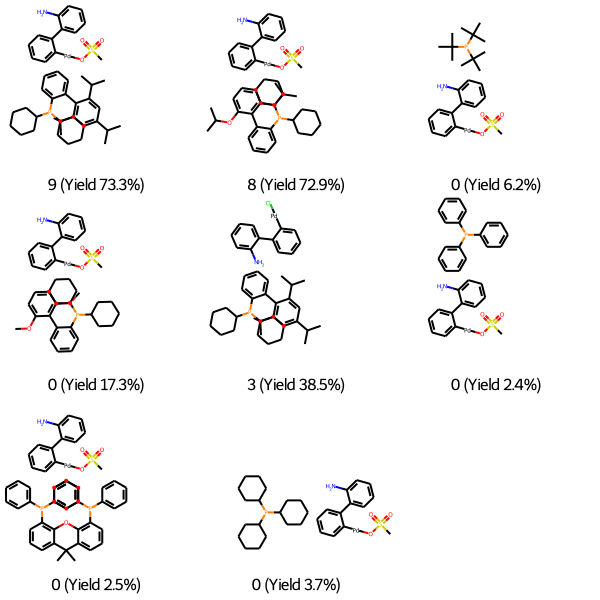

In [64]:
visualize_catalyst_choice(all_experiments[f"results_baumgartner_suzuki_cotrain_reizman_suzuki_case_3"])

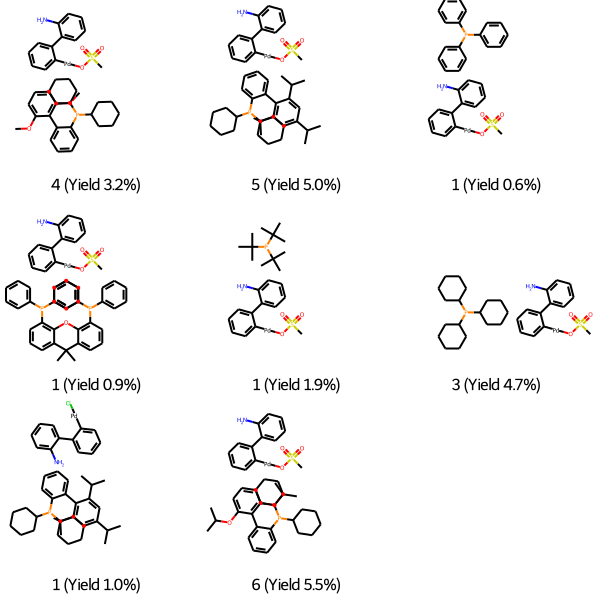

In [65]:
visualize_catalyst_choice(all_experiments_reizman_stbo[f"results_stbo_case_2"])

In [56]:
# exp = SuzukiEmulator.load(model_name="reziman_suzuki_case_4", save_dir="../data/reizman_suzuki/emulator_case_4")
data_path = Path("../data/reizman_suzuki/ord/reizman_suzuki_case_2.pb")
ds = get_suzuki_dataset(
    data_path,
    split_catalyst=False,
    print_warnings=False,
)

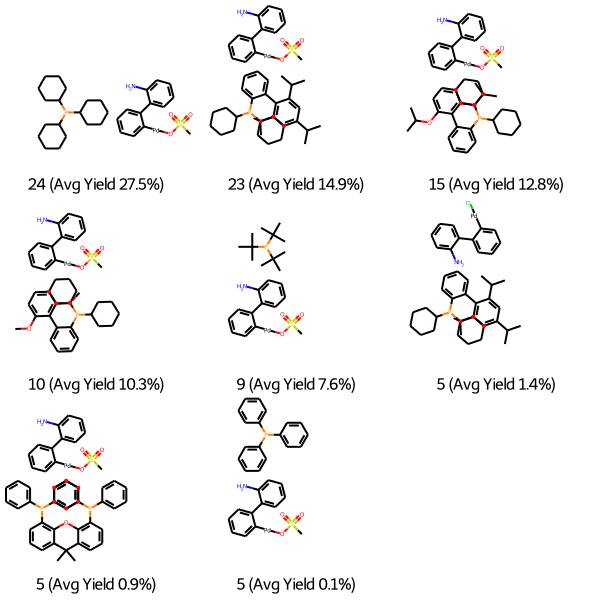

In [82]:
catalysts = ds["catalyst_smiles"].value_counts()
df = pd.DataFrame(ds.to_numpy(), columns=[c[0] for c in ds.columns])
df["yld"] = df["yld"].astype(float)
catalysts_yield = df.groupby("catalyst_smiles")["yld"].mean()
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in catalysts.index],
    legends=[f"{v} (Avg Yield {catalysts_yield[smiles]:.1f}%)" for smiles, v in zip(catalysts.index, catalysts)]
)

## Debugging

### Regular Summit

Does this work on the benchmarks directly from Summit?

In [18]:
exp = get_pretrained_reizman_suzuki_emulator()
exp.domain

Name,Type,Description,Values
catalyst,"categorical, input",Catalyst type - different ligands,8 levels
t_res,"continuous, input",Residence time in seconds (s),"[60.0,600.0]"
temperature,"continuous, input",Reactor temperature in degrees Celsius (ºC),"[30.0,110.0]"
catalyst_loading,"continuous, input",Catalyst loading in mol%,"[0.5,2.5]"
ton,"continuous, maximize objective",Turnover number - moles product generated divided by moles catalyst used,"[0.0,200.0]"
yield,"continuous, maximize objective",Yield,"[0.0,100.0]"


In [19]:
exp = get_pretrained_reizman_suzuki_emulator(case=2)
hierarchy =  {"yield": {"hierarchy": 0, "tolerance": 0.5}, "ton": {"hierarchy": 1, "tolerance": 1.0}}
transform = Chimera(exp.domain, hierarchy=hierarchy)
strategy = STBO(exp.domain, transform=transform)
r = Runner(strategy=strategy, experiment=exp, max_iterations=20)
r.run()

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/summit/strategies/base.py:697: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(arg))
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted m

<AxesSubplot:>

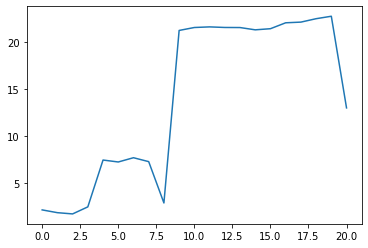

In [21]:
exp.data["yield"].plot()

yes, it does work.

### Preprocessing Check

Is there a problem with preprocessing and converting to a DataSet?

In [25]:
case_four_df = pd.read_csv(reizman_path / "reizman_suzuki_case_4.csv")

In [27]:
case_four_df.describe()

,NAME,t_res,temperature,catalyst_loading,ton,yld
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,48.000000,341.929897,86.831959,1.651722,47.690722,66.543299
std,28.145456,225.165490,23.908814,0.737427,32.076614,30.539329
min,0.000000,60.000000,30.000000,0.489000,0.000000,0.100000
25%,24.000000,154.100000,71.600000,1.096000,31.400000,53.600000
50%,48.000000,236.900000,93.000000,1.530000,39.400000,82.200000
75%,72.000000,600.000000,110.000000,2.501000,66.200000,86.500000
max,96.000000,600.000000,110.000000,2.510000,129.400000,99.800000


<AxesSubplot:>

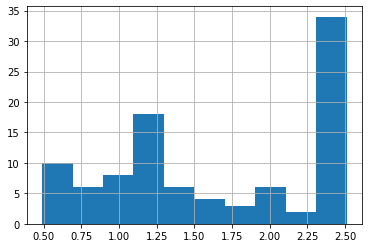

In [61]:
case_four_df["catalyst_loading"].hist()

In [4]:
# exp = SuzukiEmulator.load(model_name="reziman_suzuki_case_4", save_dir="../data/reizman_suzuki/emulator_case_4")
data_path = Path("../data/reizman_suzuki/ord/reizman_suzuki_case_4.pb")
ds = get_suzuki_dataset(
    data_path,
    split_catalyst=False,
    print_warnings=False,
)

In [9]:
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

In [10]:
dataset = message_helpers.load_message(str(data_path), dataset_pb2.Dataset)

In [15]:
volumes = [calculate_total_volume(r.inputs).magnitude for r in dataset.reactions]

In [16]:
pd.unique(volumes)

array([0.0175, 0.0335, 0.0175, 0.0335, 0.0335, 0.0335, 0.0175, 0.0335,
       0.0335, 0.0335, 0.0335, 0.0335, 0.0335, 0.0335, 0.0335, 0.0175,
       0.0175, 0.0175, 0.0335, 0.0175])

<AxesSubplot:>

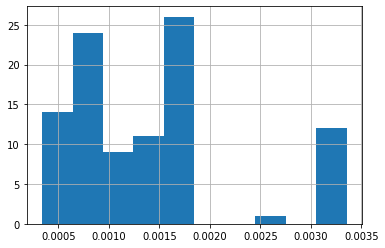

In [5]:
ds["catalyst_concentration"].hist()

<AxesSubplot:>

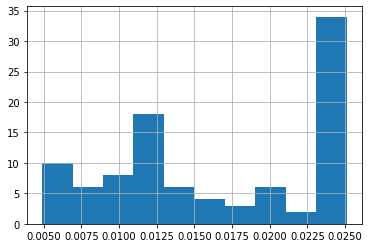

In [6]:
ds["catalyst_loading"].hist()

<AxesSubplot:>

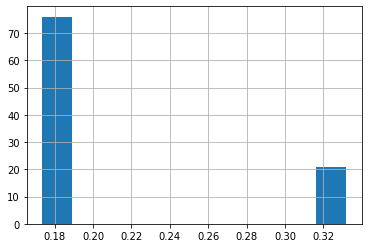

In [7]:
ds["reagent_concentration"].hist()

It seems that the issue is actually with using catalyst concentration instead of catalyst loading.

### Mixed Optimization Domain

In [47]:
exp =SuzukiEmulator.load(model_name="reizman_suzuki_case_4", save_dir="../data/reizman_suzuki/emulator_case_4/")
strategy = NewSTBO(exp.domain, brute_force_categorical=True, categorical_method=None)
r = Runner(strategy=strategy, experiment=exp, max_iterations=20)
r.run()

<AxesSubplot:>

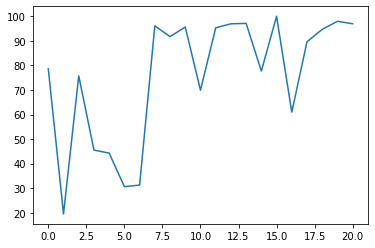

In [48]:
exp.data["yld"].plot()

In [4]:
from mixed_gp_regression import MixedMultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import (
    ExactMarginalLogLikelihood,
)

import torch

In [32]:
n1 = 20
n2 = 10
X1 = torch.cat([torch.rand(n1, 2), torch.randint(3, (n1, 1))], dim=-1)
X2 = torch.cat([torch.rand(n2, 2), torch.randint(3, (n2, 1))], dim=-1)
i1, i2 = torch.zeros(n1, 1), torch.ones(n2, 1)
train_X = torch.cat([
    torch.cat([X1, i1], -1), torch.cat([X2, i2], -1),
])
Y1 = (
        torch.sin(X1[..., :-1]).sum(dim=1, keepdim=True)
        + X1[..., -1:]
)
Y2 = 1.5*(
        torch.sin(X2[..., :-1]).sum(dim=1, keepdim=True)
        + X2[..., -1:]
)
train_Y = torch.cat((Y1, Y2))
model = MixedMultiTaskGP(train_X, train_Y, task_feature=-1, cat_dims=[-2])
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/botorch/fit.py:130: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(w.message, w.category)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/botorch/fit.py:130: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(w.message, w.category)
/Users/Kobi/Library/Caches/pypoetry/virtualenvs/multitask-z7ErTcQa-py3.7/lib/python3.7/site-packages/botorch/fit.py:130: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(w.message, w.category)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-05)
    )
  )
  (model): MixedMultiTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-05)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): AdditiveKernel(
      (kernels): ModuleList(
        (0): ScaleKernel(
          (base_kernel): AdditiveKernel(
            (kernels): ModuleList(
              (0): MaternKernel(
                (raw_lengthscale_constraint): Positive()
                (distance_module): Distance()
              )
              (1): ScaleKernel(
                (base_kernel): CategoricalKernel(
                  (raw_lengthscale_constraint): Positive()
                )
                (raw_outputscale_constraint): Positive()
              )
  

## Archive

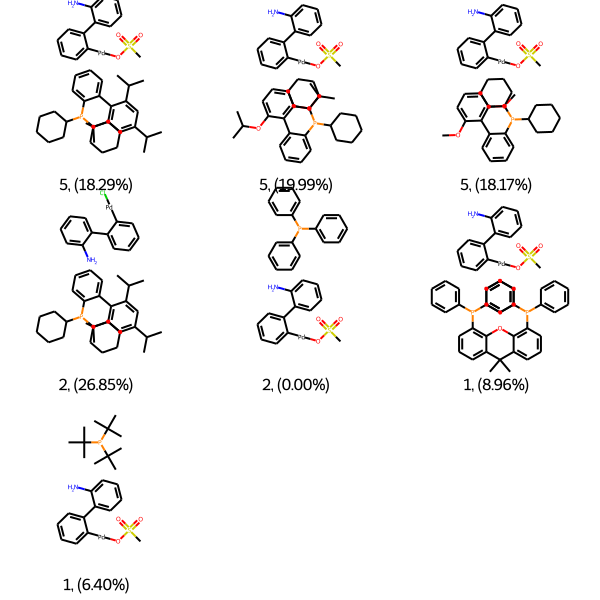

In [33]:
avg_yields = exps[0].data.groupby("catalyst_smiles")["yld"].mean()
cat_counts = exps[0].data["catalyst_smiles"].value_counts()
Chem.Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in cat_counts.index],
    legends=[f"{v}, ({avg_yields[smiles]:.2f}%)" for smiles, v in zip(cat_counts.index, cat_counts)]
)
